##**What we will cover on this notebook**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import datetime
print(f"last edit: {datetime.datetime.now()}")

last edit: 2025-09-04 08:50:04.751466


##**Check if GPU is available**

In [ ]:
import tensorflow as tf
print(f"TF version: {tf.__version__}")

TF version: 2.19.0


In [ ]:
# Check if GPU is available

gpu = tf.config.list_logical_devices('GPU')
if gpu:
  print("GPU is available", gpu)
else:
  print("GPU is not avialabe")

GPU is available [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Thu Sep  4 08:50:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             27W /   70W |     102MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##**Get helper functions and load `Cifar10` using tensorflow datasets**

In [ ]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2025-09-04 08:50:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-09-04 08:50:09 (14.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

In [ ]:
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [ ]:
# cifar10
# Set our target dataset and see if it exists
target_dataset = "cifar10"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'cifar10' in TensorFlow Datasets: True


In [ ]:
(train_data, test_data), ds_info = tfds.load(name="cifar10",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GBW6P1_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.GBW6P1_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [ ]:
# Get class names
class_names = ds_info.features['label'].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [42]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (32, 32, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 7
  Class name (str form): horse
        


In [43]:
# What does an image tensor from TFDS's Cifar10 look like?
image

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[143,  96,  70],
        [141,  96,  72],
        [135,  93,  72],
        ...,
        [ 96,  37,  19],
        [105,  42,  18],
        [104,  38,  20]],

       [[128,  98,  92],
        [146, 118, 112],
        [170, 145, 138],
        ...,
        [108,  45,  26],
        [112,  44,  24],
        [112,  41,  22]],

       [[ 93,  69,  75],
        [118,  96, 101],
        [179, 160, 162],
        ...,
        [128,  68,  47],
        [125,  61,  42],
        [122,  59,  39]],

       ...,

       [[187, 150, 123],
        [184, 148, 123],
        [179, 142, 121],
        ...,
        [198, 163, 132],
        [201, 166, 135],
        [207, 174, 143]],

       [[187, 150, 117],
        [181, 143, 115],
        [175, 136, 113],
        ...,
        [201, 164, 132],
        [205, 168, 135],
        [207, 171, 139]],

       [[195, 161, 126],
        [187, 153, 123],
        [186, 151, 128],
        ...,
        [212, 177, 147]

In [44]:
import numpy as np
pixel_value = np.array(image)
np.max(pixel_value), np.min(pixel_value)

(np.uint8(249), np.uint8(0))

In [45]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=7>

In [46]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=249>)

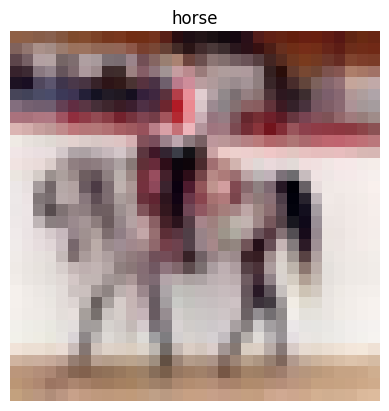

In [48]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

In [ ]:
# Normalize pixel values from 0-255 to 0-1 (size stays 32x32)

def normalize_pixel_values(image, label):
  """
  This function has a goal to convert pixel value from uint8 (0-255) to float32 (0-1)
  """

  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [ ]:
normalize_pixel_values(image=image, label=label)

(<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[0.56078434, 0.3764706 , 0.27450982],
         [0.5529412 , 0.3764706 , 0.28235295],
         [0.5294118 , 0.3647059 , 0.28235295],
         ...,
         [0.3764706 , 0.14509805, 0.07450981],
         [0.4117647 , 0.16470589, 0.07058824],
         [0.40784314, 0.14901961, 0.07843138]],
 
        [[0.5019608 , 0.38431373, 0.36078432],
         [0.57254905, 0.4627451 , 0.4392157 ],
         [0.6666667 , 0.5686275 , 0.5411765 ],
         ...,
         [0.42352942, 0.1764706 , 0.10196079],
         [0.4392157 , 0.17254902, 0.09411765],
         [0.4392157 , 0.16078432, 0.08627451]],
 
        [[0.3647059 , 0.27058825, 0.29411766],
         [0.4627451 , 0.3764706 , 0.39607844],
         [0.7019608 , 0.627451  , 0.63529414],
         ...,
         [0.5019608 , 0.26666668, 0.18431373],
         [0.49019608, 0.23921569, 0.16470589],
         [0.47843137, 0.23137255, 0.15294118]],
 
        ...,
 
        [[0.73333335, 0.5882353 , 

> 🔑: Hmmm 🤔🤔, why we define `normalize_pixel_value`, as we know NN (Neural Network) are working better with values in range (0-1), faster convergence and Stable Gradients (ignore vanishing gradient problems) and improve accuracy, in other hand if we use large numbers like 0-255 pixel values cause unstable gradients and integer values are less precise than floats for backpropation.

> **Resource:**
1. [Quatization in Neural Network](https://www.youtube.com/watch?v=idifQfmTjGE)
2. [float16-vs-float32-for-convolutional-neural-networks](https://stackoverflow.com/questions/46613748/float16-vs-float32-for-convolutional-neural-networks)

In [ ]:
def data_augmented(image, label):

  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  image = tf.image.random_hue(image, 0.1)


  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, size=[32,32,3])

  return image, label

> 🔑: https://www.youtube.com/watch?v=JI8saFjK84o

In [38]:
# Prepare training data with pixel normalization and augmentation
train_ds = train_data.map(normalize_pixel_values, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(data_augmented, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

print("Training data prepared: pixel values normalized (0-255 → 0.0-1.0)")
print("Image size remains: 32x32x3")

Training data prepared: pixel values normalized (0-255 → 0.0-1.0)
Image size remains: 32x32x3


In [27]:
# Prepare test data (only pixel normalization, no augmentation)
test_ds = test_data.map(normalize_pixel_values, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

print("Test data prepared: pixel values normalized")
print("Image size remains: 32x32x3")

Test data prepared: pixel values normalized
Image size remains: 32x32x3


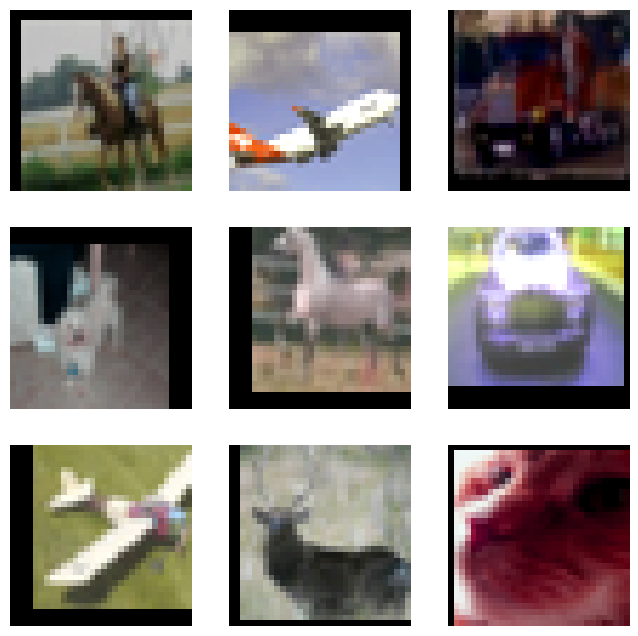

In [28]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):  # Take one batch
    plt.figure(figsize=(8,8))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_augmentations(dataset, augment_fn, num_versions=6):
    """
    Show one original image and several augmented versions side by side.


    """
    # Take one sample from the dataset
    for image, label in dataset.take(1):
        sample_image = image.numpy()
        sample_label = label.numpy()

    plt.figure(figsize=(14, 3))

    # Show original
    ax = plt.subplot(1, num_versions+1, 1)
    plt.imshow(sample_image.astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Show augmented versions
    for i in range(num_versions):
        aug_img, _ = augment_fn(sample_image, sample_label)
        ax = plt.subplot(1, num_versions+1, i+2)
        plt.imshow(aug_img.numpy().astype("uint8"))
        plt.title(f"Aug {i+1}")
        plt.axis("off")

    plt.show()


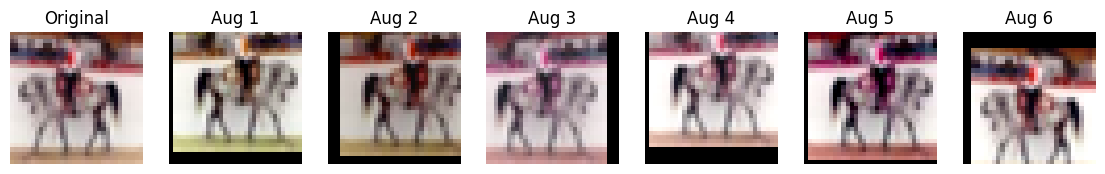

In [40]:
visualize_augmentations(train_data, data_augmented)